In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.fft
import torch.nn as nn
import torch.nn.functional as F

import torchkbnufft as tkbn
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import h5py as h5
import time
import pandas as pd
from glob import glob

# from utils import c2r

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    
print(device)

cuda


In [ ]:
import numpy as np
from skimage import io, img_as_float
from skimage.metrics import mean_squared_error

def compute_image_nrmse(img_ref, img_pred, normalisation: str = 'range') -> float:

    # 1. Convert inputs to floating point arrays in [0,1] or [0,255] → float64.
    #    If they are integer images (e.g. uint8), convert via img_as_float to range [0,1].
    #    If already float but in 0..255, you may want to normalise manually.
    img_ref_f = img_as_float(img_ref)   # ensures dtype=float64, scaled to [0,1] for typical image dtypes
    img_pred_f = img_as_float(img_pred)

    # 2. Ensure shapes match
    if img_ref_f.shape != img_pred_f.shape:
        raise ValueError(f"Shape mismatch: img_ref shape {img_ref_f.shape} vs img_pred shape {img_pred_f.shape}")

    # 3. Compute MSE (using scikit-image's mean_squared_error, which handles arbitrary shapes)
    mse_value = mean_squared_error(img_ref_f, img_pred_f)
    rmse_value = np.sqrt(mse_value)

    # 4. Choose denominator based on desired normalisation
    if normalisation == 'range':
        ref_min = np.min(img_ref_f)
        ref_max = np.max(img_ref_f)
        denom = ref_max - ref_min
        if denom == 0:
            raise ValueError("Cannot normalise by range: reference image has zero dynamic range.")
    elif normalisation == 'mean':
        ref_mean = np.mean(img_ref_f)
        if ref_mean == 0:
            raise ValueError("Cannot normalise by mean: reference image mean is zero.")
        denom = ref_mean
    elif normalisation == 'std':
        ref_std = np.std(img_ref_f)
        if ref_std == 0:
            raise ValueError("Cannot normalise by std: reference image has zero standard deviation.")
        denom = ref_std
    else:
        raise ValueError("Unsupported normalisation type. Choose 'range', 'mean' or 'std'.")

    # 5. Compute NRMSE
    nrmse_value = rmse_value / denom
    return nrmse_value

# Dataloader

In [ ]:
class modl_dataset(Dataset):
    def __init__(self, dataset_path, t_ro= 5.2e-4, gt_shape=(256,256), n_bins = 2, min_freq = -200, max_freq = 200.0):
        self.dataset_path = dataset_path
        self.ktraj, self.t_full = traj(gt_shape)
        self.nufft_ob, self.adjnufft_ob, self.dcomp = nufft_op(self.ktraj, gt_shape)
        self.t_ro = t_ro
        self.freq_bins = np.linspace(min_freq, max_freq, num= n_bins)

    def __getitem__(self, index):
        # t1 = time.time()
        zipped_imgs = np.load(sorted(glob(f"./{self.dataset_path}/imgs*"))[index])
        gt = zipped_imgs['composite']
        freq_map = zipped_imgs['freq_map']
        binned_imgs = zipped_imgs['binned_imgs']
        x0, A_img = app_traj(self.nufft_ob, self.adjnufft_ob, self.dcomp, self.ktraj, binned_imgs, self.t_full, self.freq_bins)
        gt_torch = torch.from_numpy(gt).to(dtype= torch.cfloat)
        x = torch.from_numpy(binned_imgs).to(dtype= torch.cfloat)
        # print(time.time()-t1)
        return c2r(x0), c2r(gt_torch), c2r(x.permute(-1,0,1)), A_img

    def __len__(self):
        num_data=len(glob(f"./{self.dataset_path}/imgs*"))
        return num_data
    
def traj(gt_shape):
    fov = 0.23             # [m]
    N   = int(fov / 1e-3)  # 230  → 1 mm pixels
    T_read       = 10.72e-3  # 5.2 ms total readout
    N_samp       = 3000    # samples per arm
    N_turns      = 4       # 4 revolutions
    ninterleaves = 36
    M = ninterleaves * N_samp  # total number of points
    
    # 1) Generate the spiral (in m⁻¹) plus the time stamps
    ktraj_m, t_full = simple_archimedean_spiral(
        fov, N, T_read, N_samp, N_turns, ninterleaves
    )

    delta_x = fov / N        # 1 mm = 0.001 m
    conv    = 2.0 * np.pi * delta_x
    kx_rad = conv * ktraj_m[:, 0]  # shape (M,)
    ky_rad = conv * ktraj_m[:, 1]  # shape (M,)
    ktraj_rad = np.stack((kx_rad, ky_rad), axis=0)  # (2, M)
    ktraj_torch = torch.from_numpy(ktraj_rad).float().unsqueeze(0)

    return ktraj_torch, t_full

def nufft_op(ktraj, gt_shape):
    image_size = (gt_shape[0], gt_shape[1])

    nufft_ob = tkbn.KbNufft(
    im_size=image_size
        )
    adjnufft_ob = tkbn.KbNufftAdjoint(
        im_size=image_size,
    )
    dcomp = tkbn.calc_density_compensation_function(ktraj=ktraj, im_size=image_size)

    return nufft_ob, adjnufft_ob, dcomp

def app_traj(nufft_ob, adjnufft_ob, dcomp, ktraj, binned_imgs, t_full, freq_bins):
    kdata_sum = torch.zeros((1,1, ktraj.shape[-1]), dtype= torch.cdouble)
                            
    for i in range(len(freq_bins)):
        I_bin= binned_imgs[...,i]
        I_loop = torch.tensor(I_bin,dtype=torch.cdouble).unsqueeze(0).unsqueeze(0)
        
        kdata = nufft_ob(I_loop, ktraj)
        # Construct the phase modulation matrix in k-space (complex exponential)
        Phi_np = -2.0 * np.pi * (freq_bins[i] * t_full)
        Phi = torch.from_numpy(Phi_np).float().unsqueeze(0).unsqueeze(0)
        M_delta_fi = torch.exp(1j * Phi)
        kspace_modulated = kdata * M_delta_fi*dcomp
        kdata_sum += kspace_modulated
    
    Ah_y = torch.zeros((len(freq_bins), 256, 256),dtype= torch.cdouble)

    for i in range(len(freq_bins)):
        Phi_np_conj = 2.0 * np.pi * (freq_bins[i] * t_full)
        Phi_conj = torch.from_numpy(Phi_np_conj).float().unsqueeze(0).unsqueeze(0)
        M_delta_fi_conj = torch.exp(1j * Phi_conj)
        kspace_inv = kdata_sum * M_delta_fi_conj
        Ah_y[i] = adjnufft_ob(kspace_inv, ktraj)
    A_img = adjnufft_ob(kdata_sum, ktraj)
    return Ah_y, A_img
        
   

In [ ]:
def simple_archimedean_spiral(fov, N, T_read, N_samp, N_turns, ninterleaves):

    res   = fov / N
    k_max = 1.0 / (2.0 * res)

    theta_max = 2.0 * np.pi * N_turns
    a = k_max / theta_max

    # time samples for one interleaf
    t_one_arm = np.linspace(0.0, T_read, N_samp)  # (N_samp,)
    theta_t   = (theta_max / T_read) * t_one_arm
    r_t       = a * theta_t

    # one arm, in complex form
    k_arm = r_t * np.exp(1j * theta_t)  # (N_samp,)

    # replicate for each interleaf
    arms = []
    for m in range(ninterleaves):
        offset = 2.0 * np.pi * m / ninterleaves
        arms.append(k_arm * np.exp(1j * offset))

    k_concat = np.hstack(arms)            # shape: (ninterleaves*N_samp,)
    kx = np.real(k_concat)
    ky = np.imag(k_concat)

    # also return the “time stamp” for each sample in the full concatenation
    t_full = np.hstack([t_one_arm for _ in range(ninterleaves)])
    # shape = (ninterleaves * N_samp,)

    return np.stack((kx, ky), axis=1), t_full
    # k-space (shape (M,2)), t_full (shape (M,))

# MoDL (old)

In [5]:
# def r2c(real_img, axis=0):
#     """
#     :input shape: 2 x row x col (float32)
#     :output shape: row x col (complex64)
#     """
#     if axis == 0:
#         complex_img = real_img[0] + 1j*real_img[1]
#     elif axis == 1:
#         complex_img = real_img[:,0] + 1j*real_img[:,1]
#     else:
#         raise NotImplementedError
#     return complex_img

# def c2r(complex_img, axis=0):
#     """
#     Converts a complex image tensor to a real representation with separate channels for real and imaginary parts.
#     :param complex_img: Complex image (PyTorch tensor or NumPy array)
#     :param axis: Axis along which to split real and imaginary parts (default: 0)
#     :return: Tensor with real and imaginary parts separated (dtype: float32)
#     """
#     if isinstance(complex_img, np.ndarray):
#         real_img = np.stack((complex_img.real, complex_img.imag), axis=axis)
#     elif isinstance(complex_img, torch.Tensor):
#         real_img = torch.stack((complex_img.real, complex_img.imag), axis=axis)
#         # Maintain device compatibility
#         real_img = real_img.to(dtype=torch.float, device=complex_img.device)
#     else:
#         raise NotImplementedError("Input type not supported for conversion.")
        
#     return real_img

        
 

# MoDL

In [ ]:
class AttentionModule(nn.Module):
    def __init__(self, in_channels):
        super(AttentionModule, self).__init__()
        # First 3D convolution to extract features across frequency and spatial dimensions.
        self.conv3d_1 = nn.Conv3d(in_channels, in_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)
        # Second 3D convolution to produce a single attention score per frequency bin.
        self.conv3d_2 = nn.Conv3d(in_channels, 1, kernel_size=1)
    
    def forward(self, x):
        # Extract features using a 3D convolution followed by ReLU.
        features = self.conv3d_1(x)
        features = self.relu(features)
        # Compute attention scores.
        scores = self.conv3d_2(features)
        # Apply softmax along the frequency dimension (D, index=2) to get normalised weights.
        weights = F.softmax(scores, dim=2)
        
        # Multiply input with the weights (broadcasting across channels).
        x_conv = self.conv3d_1(x)

        out = x_conv * weights
        return out, weights

class ResidualBlock(nn.Module):
    def __init__(self, channels=128, kernel_size=5):
        super().__init__()
        padding = kernel_size // 2
        self.conv1 = nn.Conv3d(channels, channels, kernel_size, padding=padding)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv3d(channels, channels, kernel_size, padding=padding)

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.relu(out)
        out = self.conv2(out)
        out += identity  # Skip connection
        out = self.relu(out)
        return out
        
class cnn_denoiser(nn.Module):
    def __init__(self, n_layers=3, in_channels=2, out_channels=2, hidden_channels=128):
        super().__init__()
        # 0) Attention module to filter frequency bins.
        self.attention = AttentionModule(hidden_channels)
        
        # 1) Initial convolution to go from in_channels -> hidden_channels.
        self.conv_in = nn.Sequential(
            nn.Conv3d(in_channels, hidden_channels, 5, padding=2),
            nn.ReLU(inplace=True),
            nn.Conv3d(hidden_channels, hidden_channels, 5, padding=2),
            nn.ReLU(inplace=True)
        )
        
        # 2) Residual blocks for refinement.
        res_blocks_layers = [ResidualBlock(channels=hidden_channels) for _ in range(n_layers)]
        self.res_blocks = nn.Sequential(*res_blocks_layers)

        # 3) Final convolution to go from hidden_channels -> out_channels.
        self.conv_out = nn.Conv3d(hidden_channels, out_channels, 5, padding=2)

    def forward(self, x):
        
        # Pass through the initial convolution.
        x_conv = self.conv_in(x)
        
        # Apply the attention module.
        x_attn, weights = self.attention(x_conv)
        
        # Process through the stack of residual blocks.
        in_betw = self.res_blocks(x_attn)
        # Final convolution to restore the number of channels.
        out = self.conv_out(in_betw + x_attn)
        # Global skip connection (using the attention output).
        return out, weights


In [ ]:
def r2c(real_img, axis=0):
    """
    :input shape: 2 x row x col (float32)
    :output shape: row x col (complex64)
    """
    if axis == 0:
        complex_img = real_img[0] + 1j*real_img[1]
    elif axis == 1:
        complex_img = real_img[0][0] + 1j*real_img[0][1]
        complex_img = complex_img.unsqueeze(0)
    else:
        raise NotImplementedError
    return complex_img

def c2r(complex_img, axis=0):
    """
    Converts a complex image tensor to a real representation with separate channels for real and imaginary parts.
    :param complex_img: Complex image (PyTorch tensor or NumPy array)
    :param axis: Axis along which to split real and imaginary parts (default: 0)
    :return: Tensor with real and imaginary parts separated (dtype: float32)
    """
    if isinstance(complex_img, np.ndarray):
        real_img = np.stack((complex_img.real, complex_img.imag), axis=axis)
    elif isinstance(complex_img, torch.Tensor):
        real_img = torch.stack((complex_img.real, complex_img.imag), axis=axis)
        # Maintain device compatibility
        real_img = real_img.to(dtype=torch.float, device=complex_img.device)
    else:
        raise NotImplementedError("Input type not supported for conversion.")
        
    return real_img

#CG algorithm ======================
class myAtA(nn.Module): # LHS of CG
    """
    performs DC step
    """
    def __init__(self, lam, min_freq, max_freq, n_bins, t_full, ktraj = None, dcomp = None, csm = None, mask=None):
        super(myAtA, self).__init__()
        self.csm = csm # complex (B x ncoil x nrow x ncol)
        self.mask = mask # complex (B x nrow x ncol)
        self.lam = lam 
        self.ktraj = ktraj
        self.dcomp = dcomp
        self.t_full =  t_full
        # self.freq_bins = 21
        self.freq_bins = np.linspace(min_freq, max_freq, num= n_bins)

    # TODO understand how to implement as single coil
    def forward(self, binned_imgs): #step for batch image
        """
        :im: complex image (B x nrow x nrol)
        """
        Ah_y = self.app_traj(nufft_ob, adjnufft_ob, self.dcomp, self.ktraj, binned_imgs.squeeze(0), self.t_full, self.freq_bins)
        return Ah_y.unsqueeze(0) + self.lam * binned_imgs

    def app_traj(self, nufft_ob, adjnufft_ob, dcomp, ktraj, binned_imgs, t_full, freq_bins):
        binned_imgs = binned_imgs.to('cpu')
        kdata_sum = torch.zeros((1,1, ktraj.shape[-1]), dtype= torch.cdouble)
                                
        for i in range(len(freq_bins)):
            I_bin= binned_imgs[i]
            I_loop = torch.tensor(I_bin,dtype=torch.cdouble).unsqueeze(0).unsqueeze(0)

            kdata = nufft_ob(I_loop, ktraj)
            Phi_np = -2.0 * np.pi * (freq_bins[i] * t_full)
            Phi = torch.from_numpy(Phi_np).float().unsqueeze(0).unsqueeze(0)
            M_delta_fi = torch.exp(1j * Phi)
            kspace_modulated = kdata * M_delta_fi*dcomp
            kdata_sum += kspace_modulated
        
        Ah_y = torch.zeros((len(freq_bins), 256, 256),dtype= torch.cdouble)
    
        for i in range(len(freq_bins)):
            Phi_np_conj = 2.0 * np.pi * (freq_bins[i] * t_full)
            Phi_conj = torch.from_numpy(Phi_np_conj).float().unsqueeze(0).unsqueeze(0)
            M_delta_fi_conj = torch.exp(1j * Phi_conj)
            kspace_inv = kdata_sum * M_delta_fi_conj
            Ah_y[i] = adjnufft_ob(kspace_inv, ktraj)
        return Ah_y.to('cuda')


def myCG(AtA, rhs):
    """
    Performs Conjugate Gradient (CG) algorithm
    :param AtA: A class object that contains forward and adjoint operations
    :param rhs: Right-hand side vector (complex tensor)
    """
    rhs = r2c(rhs, axis=1)  # Convert to complex form if needed
    # print(rhs.shape)
    x = torch.zeros_like(rhs)  # Initial guess
    r = rhs - AtA(x)  # Initial residual
    p = r.clone()
    rTr = torch.sum(r.conj() * r).real

    for i in range(12):
        if rTr < 1e-12:
            break
        Ap = AtA(p)
        alpha = rTr / torch.sum(p.conj() * Ap).real
        x = x + alpha * p
        r = r - alpha * Ap
        rTrNew = torch.sum(r.conj() * r).real
        beta = rTrNew / rTr
        p = r + beta * p
        rTr = rTrNew
    # print(x.shape)
    # print(c2r(x).shape)
    return c2r(x,1)  # Convert back to real representation


class data_consistency(nn.Module):
    def __init__(self):
        super().__init__()
        self.lam = nn.Parameter(torch.tensor(1.0), requires_grad=True)

    def forward(self, z_k, x0, min_freq, max_freq, n_bins, ktraj, t_full, dcomp):
        rhs = x0 + self.lam * z_k # (2, nrow, ncol)
        # print(f'rhs: {ktraj.size()}')
        AtA = myAtA(self.lam, min_freq, max_freq, n_bins, t_full, ktraj, dcomp)
        rec = myCG(AtA, rhs)
        return rec
    

#model =======================    
class MoDL(nn.Module):
    def __init__(self, n_layers, k_iters, min_freq, max_freq, n_bins, ktraj, t_full, dcomp):
        """
        :n_layers: number of layers
        :k_iters: number of iterations
        """
        super().__init__()
        self.k_iters = k_iters
        self.dw = cnn_denoiser(n_layers) # layers, input bins, output bins
        self.dc = data_consistency()
        self.min_freq = min_freq
        self.max_freq = max_freq
        self.n_bins = n_bins
        self.dcomp = dcomp
        self.ktraj = ktraj
        self.t_full= t_full

    def forward(self, x0, csm=None, mask=None):
        """
        :x0: zero-filled reconstruction (B, 2, nrow, ncol) - float32
        :csm: coil sensitivity map (B, ncoil, nrow, ncol) - complex64
        :mask: sampling mask (B, nrow, ncol) - int8
        """

        x_k = x0.clone() #(2, H, W)
        for k in range(self.k_iters):
            # print(k)
            #dw 
            # print(self.ktraj.shape)
            z_k, weights = self.dw(x_k) # (2, nrow, ncol); z_k = denoised x_k
            #dc
            x_k = self.dc(z_k, x0, self.min_freq, self.max_freq,self.n_bins, self.ktraj, self.t_full, self.dcomp) # (2, nrow, ncol)
            # x_k = self.dc(z_k, x0, csm, mask) # (2, nrow, ncol)
        x_k=x_k
        # 
        # print(x_k.shape)
        # print(x_summed.shape)
        # for i in range(21):
            
        return x_k,weights

# Trainer

In [10]:
def train_network(model, loss_func, train_loader, val_loader=None, test_loader=None,score_funcs=None, 
                         epochs=50, device="cpu", checkpoint_file=None, 
                         lr_schedule=None, optimizer=None, disable_tqdm=False
                        ):
    """Train simple neural networks
    
    Keyword arguments:
    model -- the PyTorch model / "Module" to train
    loss_func -- the loss function that takes in batch in two arguments, the model outputs and the labels, and returns a score
    train_loader -- PyTorch DataLoader object that returns tuples of (input, label) pairs. 
    val_loader -- Optional PyTorch DataLoader to evaluate on after every epoch
    test_loader -- Optional PyTorch DataLoader to evaluate on after every epoch
    score_funcs -- A dictionary of scoring functions to use to evalue the performance of the model
    epochs -- the number of training epochs to perform
    device -- the compute lodation to perform training
    lr_schedule -- the learning rate schedule used to alter \eta as the model trains. If this is not None than the user must also provide the optimizer to use. 
    optimizer -- the method used to alter the gradients for learning. 
    
    """
    if score_funcs == None:
        score_funcs = {}#Empty set 
    
    to_track = ["epoch", "total time", "train loss"]
    if val_loader is not None:
        to_track.append("val loss")
    if test_loader is not None:
        to_track.append("test loss")
    for eval_score in score_funcs:
        to_track.append("train " + eval_score )
        if val_loader is not None:
            to_track.append("val " + eval_score )
        if test_loader is not None:
            to_track.append("test "+ eval_score )
        
    total_train_time = 0 #How long have we spent in the training loop? 
    results = {}
    #Initialize every item with an empty list
    for item in to_track:
        results[item] = []

        
    if optimizer == None:
        #The AdamW optimizer is a good default optimizer
        optimizer = torch.optim.AdamW(model.parameters())
        del_opt = True
    else:
        del_opt = False

    #Place the model on the correct compute resource (CPU or GPU)
    model.to(device)
    for epoch in tqdm(range(epochs), desc="Epoch", disable=disable_tqdm):
        model = model.train()#Put our model in training mode

        total_train_time += run_epoch(model, optimizer, train_loader, loss_func, device, results, score_funcs, prefix="train", desc="Training")
        
        results["epoch"].append( epoch )
        results["total time"].append( total_train_time )
        
      
        if val_loader is not None:
            model = model.eval() #Set the model to "evaluation" mode, b/c we don't want to make any updates!
            with torch.no_grad():
                run_epoch(model, optimizer, val_loader, loss_func, device, results, score_funcs, prefix="val", desc="Validating")
                
        #In PyTorch, the convention is to update the learning rate after every epoch
        if lr_schedule is not None:
            if isinstance(lr_schedule, torch.optim.lr_scheduler.ReduceLROnPlateau):
                lr_schedule.step(results["val loss"][-1])
            else:
                lr_schedule.step()
                
        if test_loader is not None:
            model = model.eval() #Set the model to "evaluation" mode, b/c we don't want to make any updates!
            with torch.no_grad():
                run_epoch(model, optimizer, test_loader, loss_func, device, results, score_funcs, prefix="test", desc="Testing")
        
        
        if checkpoint_file is not None:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'results' : results
                }, checkpoint_file)
    if del_opt:
        del optimizer

    return pd.DataFrame.from_dict(results)

<>:5: SyntaxWarning: invalid escape sequence '\e'
<>:5: SyntaxWarning: invalid escape sequence '\e'
/var/tmp/pbs.510371.pbs-7/ipykernel_2342285/1140411722.py:5: SyntaxWarning: invalid escape sequence '\e'
  """Train simple neural networks


In [ ]:
def run_epoch(model, optimizer, data_loader, loss_func, device, results, score_funcs, prefix="", desc=None):
    """
    model -- the PyTorch model / "Module" to run for one epoch
    optimizer -- the object that will update the weights of the network
    data_loader -- DataLoader object that returns tuples of (input, label) pairs. 
    loss_func -- the loss function that takes in two arguments, the model outputs and the labels, and returns a score
    device -- the compute lodation to perform training
    score_funcs -- a dictionary of scoring functions to use to evalue the performance of the model
    prefix -- a string to pre-fix to any scores placed into the _results_ dictionary. 
    desc -- a description to use for the progress bar.     
    """
    running_loss = []
    # y_true_list = []  # to accumulate ground truth for evaluation
    # y_pred_list = []  # to accumulate predictions for evaluation
    start = time.time()
    for (x0, y, x) in tqdm(data_loader, desc=desc, leave=False):
        x0, y, x= x0.to(device), y.to(device), x.to(device)
        # print(freq_map.size())
#         with torch.set_grad_enabled():
        x_hat, weights = model(x0)
        x_summed = torch.sum(x_hat, 2)
        # print(weights.shape)
        loss_bins = loss_func(x_hat, x)
        # print(loss_bins.shape)
        # loss_per_D = loss_bins.mean(dim=(1, 3, 4))
        # loss_freq = loss_func(weights, freq_map.unsqueeze(0).unsqueeze(0))
        
        loss_summed = loss_func(x_summed, y)
        # total_loss = loss_per_D.sum() + loss_summed.mean()
        # total_loss = loss_bins + loss_summed
        # total_loss = loss_per_D.mean()
        total_loss = loss_bins + loss_summed
        
        print(total_loss)
        if model.training:
            # print("training")
            total_loss.backward()
            # nn.utils.clip_grad_value_(model.parameters(), clip_value=1.0)
            optimizer.step()
            optimizer.zero_grad()

        #Now we are just grabbing some information we would like to have
        running_loss.append(total_loss.item())
    # End of epoch: record epoch loss and compute scores
    end = time.time()
    
    results[prefix + " loss"].append(np.mean(running_loss))
    print("Epoch Loss:", np.mean(running_loss))

    return end - start  # time spent on epoch

In [12]:
def moveTo(obj, device):
    """
    obj: the python object to move to a device, or to move its contents to a device
    device: the compute device to move objects to
    """
    if hasattr(obj, "to"):
        return obj.to(device)
    elif isinstance(obj, list):
        return [moveTo(x, device) for x in obj]
    elif isinstance(obj, tuple):
        return tuple(moveTo(list(obj), device))
    elif isinstance(obj, set):
        return set(moveTo(list(obj), device))
    elif isinstance(obj, dict):
        to_ret = dict()
        for key, value in obj.items():
            to_ret[moveTo(key, device)] = moveTo(value, device)
        return to_ret
    else:
        return obj

# Start

In [13]:
path = "synthethic_imgs_11bins_sharp_softbins"
dataset = modl_dataset(dataset_path = path,n_bins = 11, min_freq = -220, max_freq =220)

/var/tmp/pbs.510371.pbs-7/ipykernel_2342285/3487948212.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(np.abs(gt_img))


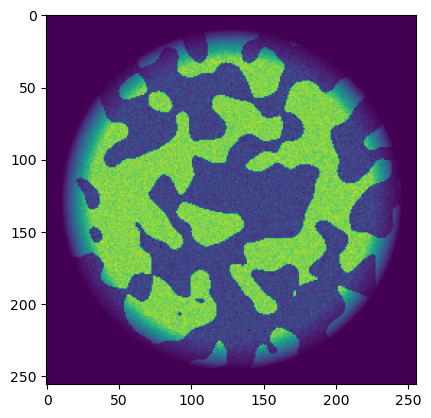

In [14]:
gt_img = r2c(dataset[0][1],0)
plt.imshow(np.abs(gt_img))

/var/tmp/pbs.510371.pbs-7/ipykernel_2342285/411862852.py:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(np.abs(tst_img[0]))
/var/tmp/pbs.510371.pbs-7/ipykernel_2342285/411862852.py:8: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(np.abs(tst_img[1]))


torch.Size([256, 256])

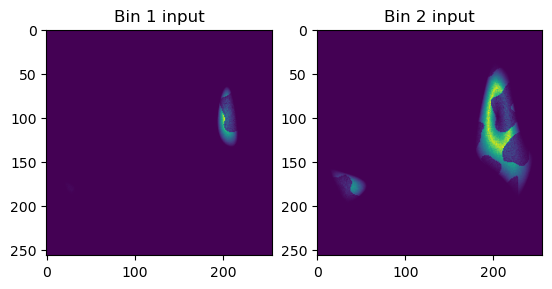

In [15]:
tst_img = r2c(dataset[0][2], 0)
plt.subplot(121)
plt.imshow(np.abs(tst_img[0]))
plt.title("Bin 1 input")
# plt.gray()

plt.subplot(122)
plt.imshow(np.abs(tst_img[1]))
plt.title("Bin 2 input")
# plt.gray()
tst_img[1].shape

/var/tmp/pbs.510371.pbs-7/ipykernel_2342285/475080409.py:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(np.abs(tst_img[0].cpu()))
/var/tmp/pbs.510371.pbs-7/ipykernel_2342285/475080409.py:9: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(np.abs(tst_img[4].cpu()))


(np.float64(-0.5), np.float64(255.5), np.float64(255.5), np.float64(-0.5))

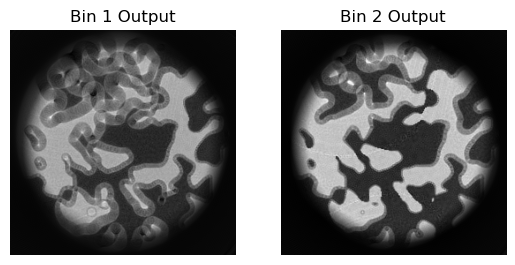

In [16]:
tst_img = r2c(dataset[0][0],0)
plt.subplot(121)
plt.imshow(np.abs(tst_img[0].cpu()))
plt.title("Bin 1 Output")
plt.gray()
plt.axis('off')

plt.subplot(122)
plt.imshow(np.abs(tst_img[4].cpu()))
plt.title("Bin 2 Output")
plt.gray()
plt.axis('off')

/var/tmp/pbs.510371.pbs-7/ipykernel_2342285/3830193117.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(np.abs(tst_img[0].cpu()-gt_bin_img[0].cpu()))


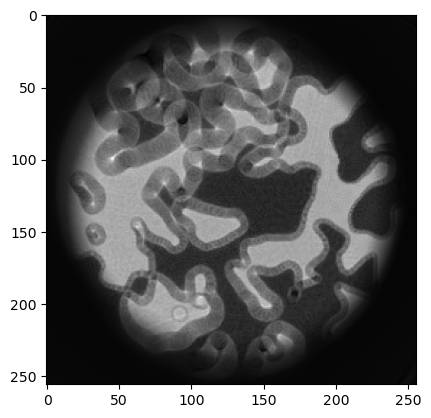

In [17]:
gt_bin_img = r2c(dataset[0][2], 0)
plt.imshow(np.abs(tst_img[0].cpu()-gt_bin_img[0].cpu()))

In [18]:
dataloaders = DataLoader(dataset, batch_size=1, shuffle = True)

In [19]:
loss_func = nn.L1Loss()
n_layer = 3
k_iter= 4
n_bins = 11
min_freq = -220
max_freq = 220
image_size = (256,256)
ktraj = dataset.ktraj
t_full = dataset.t_full
nufft_ob = tkbn.KbNufft(
        im_size=image_size
        )
adjnufft_ob = tkbn.KbNufftAdjoint(
    im_size=image_size,
    )
dcomp = tkbn.calc_density_compensation_function(ktraj=ktraj, im_size=image_size)
model = MoDL(n_layer, k_iter, min_freq, max_freq, n_bins, ktraj, t_full, dcomp)
model = model.to(device)
optimizer =torch.optim.AdamW(model.parameters(), lr=1e-5) 

In [27]:
torch.cuda.memory_allocated(0)

249300992

In [25]:
torch.cuda.get_device_properties(0).total_memory

47725936640

In [24]:
modl_results = train_network(model, loss_func, dataloaders, epochs=30, device=device, optimizer=optimizer, checkpoint_file="modl_020625_spiral.pth")

Epoch:   0%|          | 0/30 [00:00<?, ?it/s]
/var/tmp/pbs.487668.pbs-7/ipykernel_1831101/877138473.py:133: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  I_loop = torch.tensor(I_bin,dtype=torch.cdouble).unsqueeze(0).unsqueeze(0)


tensor(0.0772, device='cuda:0', grad_fn=<AddBackward0>)



Epoch:   0%|          | 0/30 [02:03<?, ?it/s]               
/var/tmp/pbs.487668.pbs-7/ipykernel_1831101/1140411722.py:5: SyntaxWarning: invalid escape sequence '\e'
  """Train simple neural networks


KeyboardInterrupt: 

In [ ]:
modl_results.plot(x='epoch', y='train loss')

# Eval

In [23]:
checkpoint = torch.load('modl_020625_attn_sharp_fw_fmap_11bin_softbins_spiral.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
# loss = checkpoint['loss']

model.eval()

/var/tmp/pbs.510371.pbs-7/ipykernel_2342285/2147653823.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('modl_020625_attn_sharp_fw_fmap_11bin_soft

MoDL(
  (dw): cnn_denoiser(
    (attention): AttentionModule(
      (conv3d_1): Conv3d(128, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
      (relu): ReLU(inplace=True)
      (conv3d_2): Conv3d(128, 1, kernel_size=(1, 1, 1), stride=(1, 1, 1))
    )
    (conv_in): Sequential(
      (0): Conv3d(2, 128, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(2, 2, 2))
      (1): ReLU(inplace=True)
      (2): Conv3d(128, 128, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(2, 2, 2))
      (3): ReLU(inplace=True)
    )
    (res_blocks): Sequential(
      (0): ResidualBlock(
        (conv1): Conv3d(128, 128, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(2, 2, 2))
        (relu): ReLU(inplace=True)
        (conv2): Conv3d(128, 128, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(2, 2, 2))
      )
      (1): ResidualBlock(
        (conv1): Conv3d(128, 128, kernel_size=(5, 5, 5), stride=(1, 1, 1), padding=(2, 2, 2))
        (relu): ReLU(inplace=True)
        (conv2): Conv

# Brain MRI

In [20]:
from SyntheticDataGenerator_sharp import SyntheticDataGenerator_sharp
class brain_dataset(Dataset):
    def __init__(self, mode, dataset_path, gt_shape=(256,256)):
        """
        :sigma: std of Gaussian noise to be added in the k-space
        """
        self.prefix = 'trn' if mode == 'train' else 'tst'
        self.dataset_path = dataset_path
#         self.sigma = sigma
    

    def __getitem__(self, index):
        """
        :x0: zero-filled reconstruction (2 x nrow x ncol) - float32
        :gt: fully-sampled image (2 x nrow x ncol) - float32
        :csm: coil sensitivity map (ncoil x nrow x ncol) - complex64
        :mask: undersample mask (nrow x ncol) - int8
        """
        with h5.File(self.dataset_path, 'r') as f:
            gt = f[self.prefix+'Org'][index]
            gt = np.abs(gt)
            gt_torch = F.interpolate(torch.from_numpy(gt).unsqueeze(0).unsqueeze(0), (256, 256))
            gt_torch = gt_torch.squeeze(0).squeeze(0).to(dtype=complex)
        return gt_torch

    def __len__(self):
        with h5.File(self.dataset_path, 'r') as f:
            num_data = len(f[self.prefix+'Mask'])
        return num_data
    

In [53]:
mode = "test"
path = "dataset.hdf5"

dataset_test = brain_dataset(mode = mode, dataset_path = path)

/var/tmp/pbs.510060.pbs-7/ipykernel_3798969/1432087129.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(np.abs(tst_brain_img))


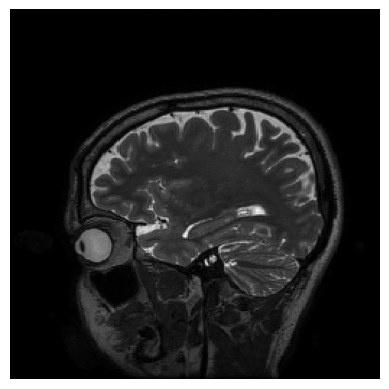

In [80]:
tst_brain_img = dataset_test[50]
plt.imshow(np.abs(tst_brain_img))
plt.axis('off')
plt.gray()

plt.savefig(f'{save_path}/brain_img_summed_gt.png', format='png', dpi=200, bbox_inches="tight", transparent=True)
plt.savefig(f'{save_path}/brain_img_summed_gt.eps', format='eps', dpi=200, bbox_inches="tight", transparent=True)

In [55]:
nx, ny = 256, 256
min_freq = -220
max_freq = 220
n_images = 1
num_bins = 12
data_gen = SyntheticDataGenerator_sharp(nx, ny, n_images, min_freq, max_freq)
freq_map = data_gen.generate_field_map()
# binned_imgs = np.expand_dims(data_gen.create_freq_bin_image(tst_brain_img, freq_map, num_bins), axis=0)
binned_imgs= data_gen.create_soft_freq_bin_image(tst_brain_img,freq_map, min_freq, max_freq, num_bins-1)


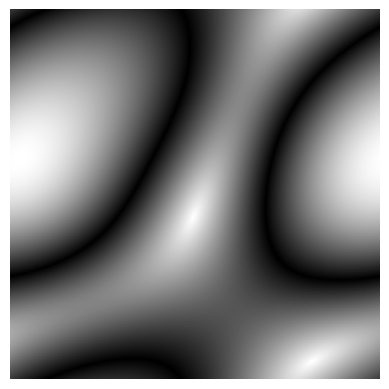

In [73]:
plt.imshow(np.abs(freq_map))
plt.gray()
plt.axis('off')
plt.savefig(f'{save_path}/freq_map.png', format='png', dpi=200, bbox_inches="tight", transparent=True)

/var/tmp/pbs.510060.pbs-7/ipykernel_3798969/1865512628.py:6: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(np.abs(binned_imgs[0][...,i]))


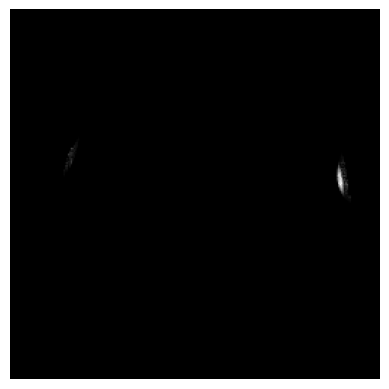

In [79]:
# binned_imgs = binned_imgs[..]
# plt.figure(figsize=(12,4))
for i in range(num_bins-1):
    # plt.subplot(1, num_bins, i+1)
    # plt.imshow(np.abs(fat_map), cmap ='gray')
    plt.imshow(np.abs(binned_imgs[0][...,i]))
    plt.gray()
    plt.axis('off')
    plt.savefig(f'{save_path}/brain_img_gt_bin_{i}.png', format='png', dpi=200, bbox_inches="tight", transparent=True)
    plt.savefig(f'{save_path}/brain_img_gt_bin_{i}.eps', format='eps', dpi=200, bbox_inches="tight", transparent=True)

/var/tmp/pbs.510060.pbs-7/ipykernel_3798969/1193320978.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(np.abs(tst_brain_img))
/var/tmp/pbs.510060.pbs-7/ipykernel_3798969/1193320978.py:9: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(np.abs(binned_imgs[0][...,0]))
/var/tmp/pbs.510060.pbs-7/ipykernel_3798969/1193320978.py:14: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(np.abs(binned_imgs[0][...,1]))


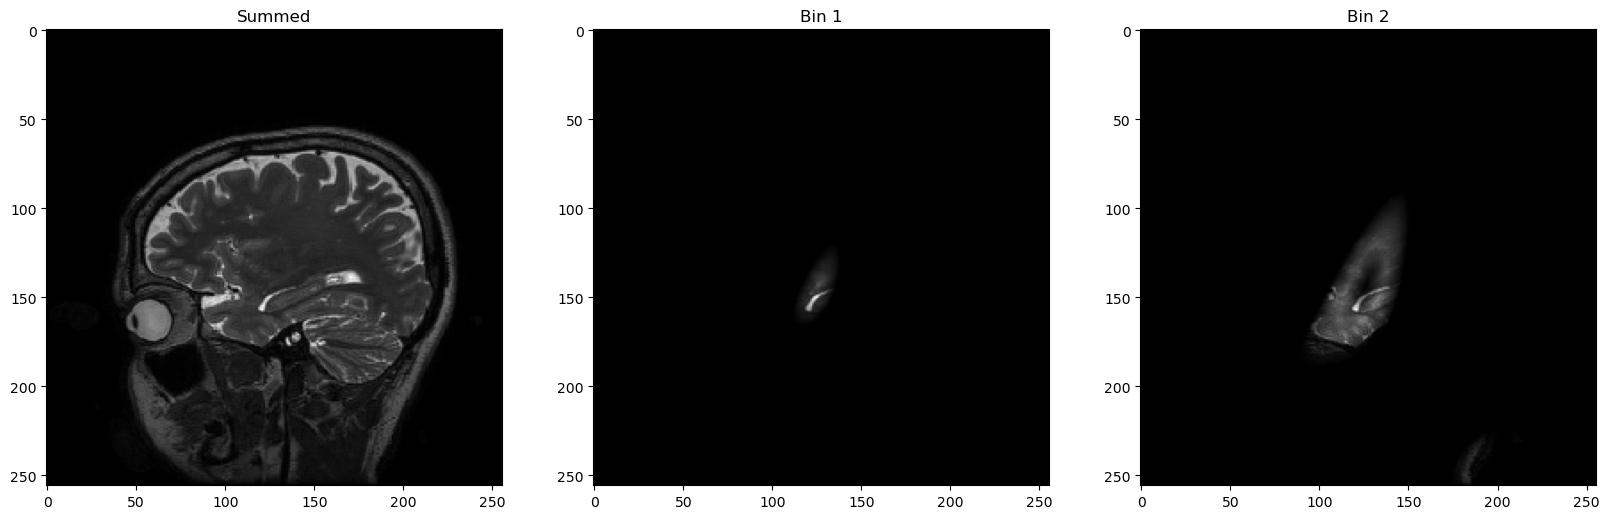

In [58]:
plt.figure(figsize=(20,10))

plt.subplot(131)
plt.imshow(np.abs(tst_brain_img))
plt.title("Summed")
plt.gray()

plt.subplot(132)
plt.imshow(np.abs(binned_imgs[0][...,0]))
plt.title("Bin 1")
plt.gray()

plt.subplot(133)
plt.imshow(np.abs(binned_imgs[0][...,1]))
plt.title("Bin 2")
plt.gray()

# plt.savefig('modl_recon_c_50')

In [60]:
n_bins = 11
min_freq = -220
max_freq = 220.0
freq_bins = np.linspace(min_freq, max_freq, num= n_bins)

x0, A_img= app_traj(nufft_ob, adjnufft_ob, dcomp, ktraj, binned_imgs[0], t_full, freq_bins)

/var/tmp/pbs.510060.pbs-7/ipykernel_3798969/4056196806.py:83: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  I_loop = torch.tensor(I_bin,dtype=torch.cdouble).unsqueeze(0).unsqueeze(0)


/var/tmp/pbs.510060.pbs-7/ipykernel_3798969/2248630347.py:2: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(np.abs(x0[0]))
/var/tmp/pbs.510060.pbs-7/ipykernel_3798969/2248630347.py:7: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(np.abs(x0[10]))


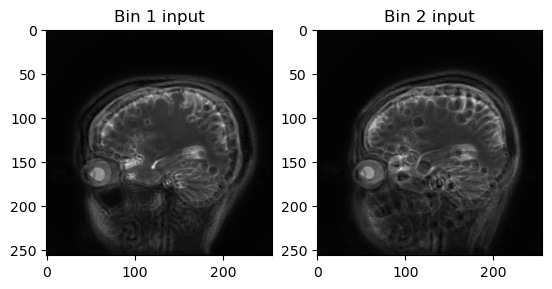

In [74]:
plt.subplot(121)
plt.imshow(np.abs(x0[0]))
plt.title("Bin 1 input")
plt.gray()

plt.subplot(122)
plt.imshow(np.abs(x0[10]))
plt.title("Bin 2 input")
plt.gray()

In [62]:
with torch.no_grad():
    tst_data, weights = model(c2r(torch.tensor(x0, dtype=torch.cdouble)).to(device).unsqueeze(0))
# summed_img = r2c(tst_data[1].squeeze(0).detach().cpu())
# binned_img = r2c(tst_data[0].squeeze(0).detach().cpu()) 

/var/tmp/pbs.510060.pbs-7/ipykernel_3798969/2926061005.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tst_data, weights = model(c2r(torch.tensor(x0, dtype=torch.cdouble)).to(device).unsqueeze(0))
/var/tmp/pbs.510060.pbs-7/ipykernel_3798969/877138473.py:133: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  I_loop = torch.tensor(I_bin,dtype=torch.cdouble).unsqueeze(0).unsqueeze(0)


In [63]:
# summed_img = r2c(tst_data[1].squeeze(0).detach().cpu())
binned_img = r2c(tst_data[0].squeeze(0).detach().cpu()) 

In [69]:
binned_imgs[0].shape

torch.Size([256, 256, 11])

/var/tmp/pbs.510060.pbs-7/ipykernel_3798969/3566657013.py:7: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(np.abs(binned_img[i]))


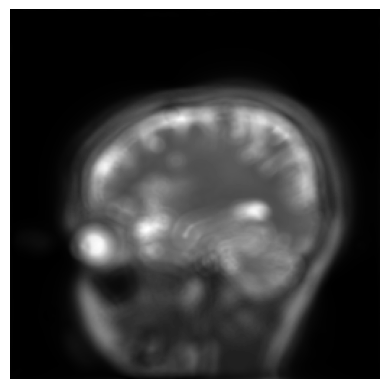

In [82]:
binned_img = r2c(tst_data[0].squeeze(0).detach().cpu()) 
summed_img = np.zeros_like(binned_img[0])
# plt.figure(figsize=(20,40))
for i in range(n_bins):
    # plt.subplot(1,n_bins, i +1)
    
    plt.imshow(np.abs(binned_img[i]))
    plt.axis('off')
    # plt.title(f"Output Bin {i}")
    plt.gray()
    # plt.savefig(f'{save_path}/brain_img_out_bin_{i}.png', format='png', dpi=200, bbox_inches="tight", transparent=True)
    # plt.savefig(f'{save_path}/brain_img_out_bin_{i}.eps', format='eps', dpi=200, bbox_inches="tight", transparent=True)
    summed_img += binned_img[i].numpy()

plt.imshow(np.abs(summed_img))
plt.axis('off')
plt.gray()

# plt.savefig(f'{save_path}/brain_img_summed_out.png', format='png', dpi=200, bbox_inches="tight", transparent=True)
# plt.savefig(f'{save_path}/brain_img_summed_out.eps', format='eps', dpi=200, bbox_inches="tight", transparent=True)

/var/tmp/pbs.510060.pbs-7/ipykernel_3798969/981275371.py:9: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(np.abs(binned_img[0]))
/var/tmp/pbs.510060.pbs-7/ipykernel_3798969/981275371.py:14: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(np.abs(binned_img[10]))


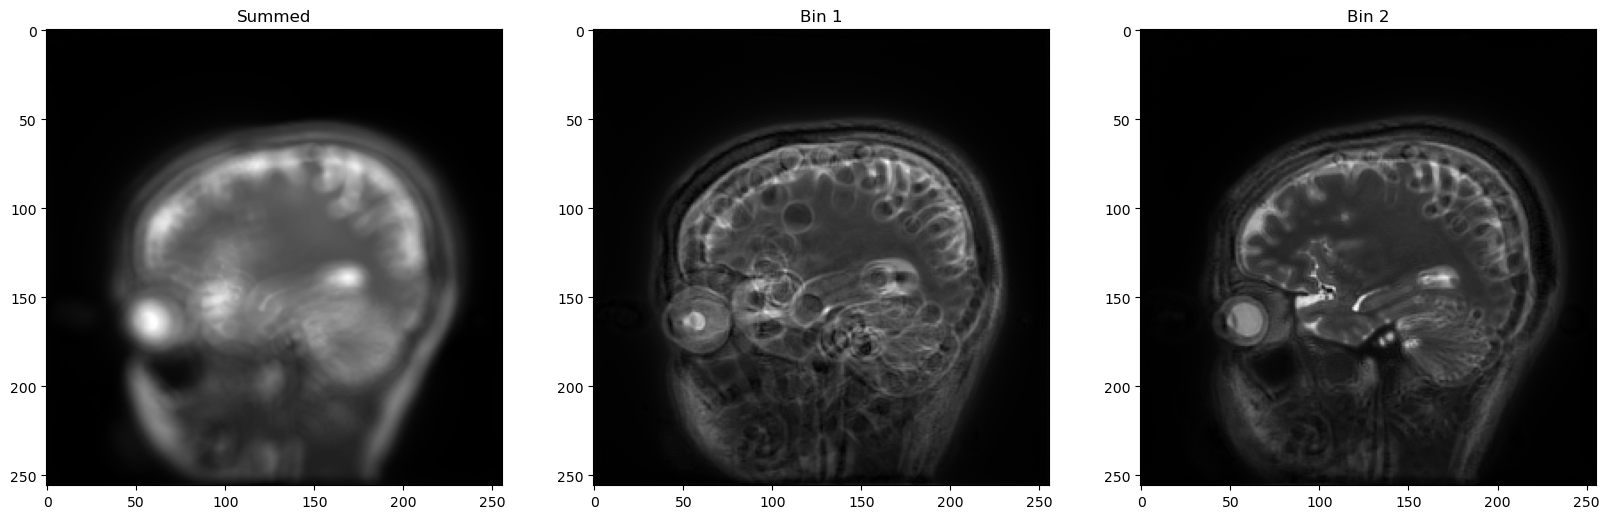

In [38]:
plt.figure(figsize=(20,10))

plt.subplot(131)
plt.imshow(np.abs(summed_img))
plt.title("Summed")
plt.gray()

plt.subplot(132)
plt.imshow(np.abs(binned_img[0]))
plt.title("Bin 1")
plt.gray()

plt.subplot(133)
plt.imshow(np.abs(binned_img[10]))
plt.title("Bin 2")
plt.gray()

# plt.savefig('modl_recon_c_50')

/var/tmp/pbs.510060.pbs-7/ipykernel_3798969/2056575231.py:1: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(np.abs(binned_img[0]-x0[0]))


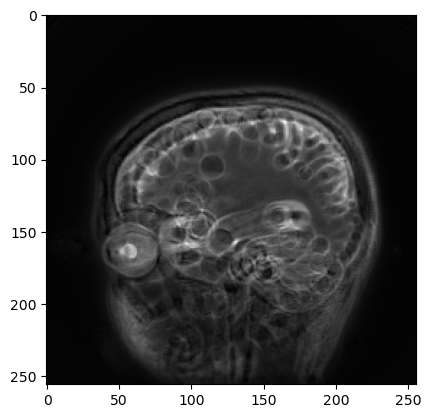

In [42]:
plt.imshow(np.abs(binned_img[0]-x0[0]))

In [83]:
nrmse_result = compute_image_nrmse(np.abs(tst_brain_img), np.abs(summed_img), normalisation='range')

/var/tmp/pbs.510060.pbs-7/ipykernel_3798969/184491621.py:1: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  nrmse_result = compute_image_nrmse(np.abs(tst_brain_img), np.abs(summed_img), normalisation='range')


# Synthetic Data

In [26]:
idx = 40
n_bins = 11
with torch.no_grad():
    tst_data, weights = model(dataset[idx][0].to(device).unsqueeze(0))

# tst_data = model(dataset[55][0].to(device).unsqueeze(0))
# tst_data[0].type()

/var/tmp/pbs.510371.pbs-7/ipykernel_2342285/877138473.py:133: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  I_loop = torch.tensor(I_bin,dtype=torch.cdouble).unsqueeze(0).unsqueeze(0)


In [89]:
tst_data[0].shape

torch.Size([2, 11, 256, 256])

In [85]:
gt_img=dataset[idx][1]

In [86]:
gt_img.shape

torch.Size([2, 256, 256])

In [19]:
summed_img = r2c(tst_data[1].squeeze(0).detach().cpu())
binned_img = r2c(tst_data[0].squeeze(0).detach().cpu()) 

In [29]:
binned_img.shape

torch.Size([2, 256, 256])

In [ ]:
nrmse_result = compute_image_nrmse(np.abs(tst_brain_img), np.abs(summed_img), normalisation='range')

/var/tmp/pbs.239276.pbs-7/ipykernel_2356240/1970350626.py:4: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(np.abs(summed_img))
/var/tmp/pbs.239276.pbs-7/ipykernel_2356240/1970350626.py:9: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(np.abs(binned_img[0]))
/var/tmp/pbs.239276.pbs-7/ipykernel_2356240/1970350626.py:14: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(np.abs(binned_img[1]))


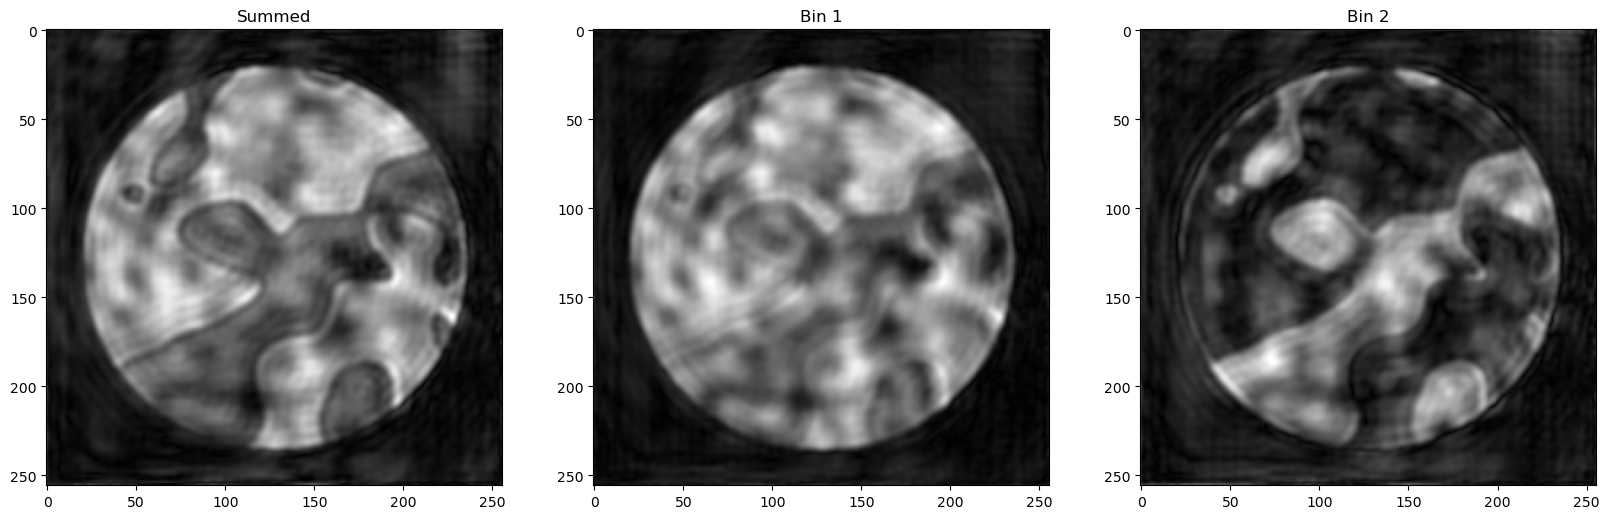

In [20]:
plt.figure(figsize=(20,10))

plt.subplot(131)
plt.imshow(np.abs(summed_img))
plt.title("Summed")
plt.gray()

plt.subplot(132)
plt.imshow(np.abs(binned_img[0]))
plt.title("Bin 1")
plt.gray()

plt.subplot(133)
plt.imshow(np.abs(binned_img[1]))
plt.title("Bin 2")
plt.gray()

plt.savefig('modl_recon_c_50')

/var/tmp/pbs.239276.pbs-7/ipykernel_2356240/3664576002.py:67: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  M_delta_fi = np.exp(-1j * 2 * np.pi * freq_bins[i] * t)
/var/tmp/pbs.239276.pbs-7/ipykernel_2356240/1044682863.py:14: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(np.abs(tst_binned[0]))
/var/tmp/pbs.239276.pbs-7/ipykernel_2356240/1044682863.py:19: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(np.abs(tst_binned[1]))


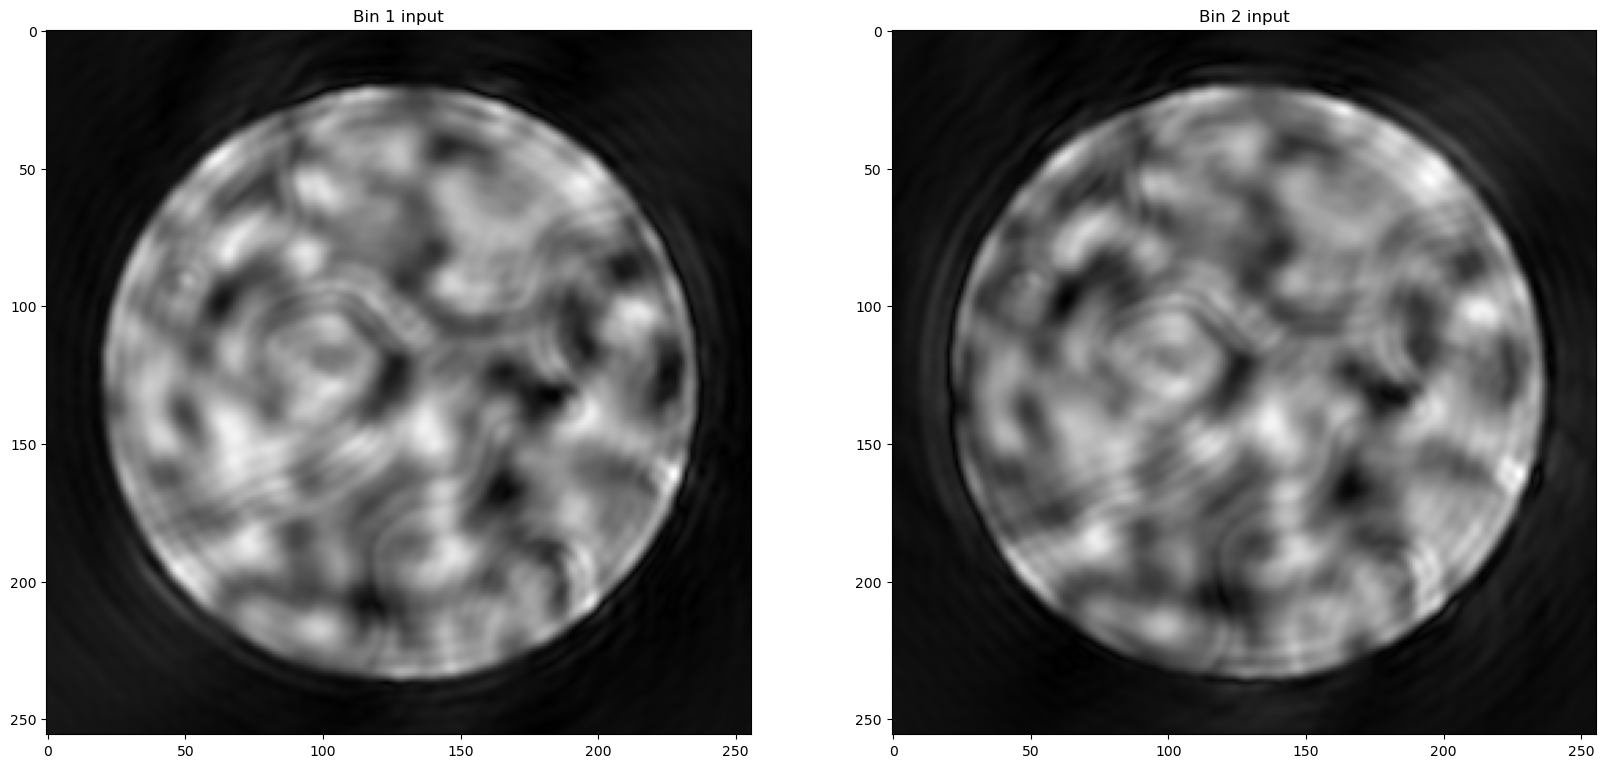

In [21]:
path = "synthethic_imgs_2_chan"
dataset = modl_dataset(dataset_path = path)
tst_binned = r2c(dataset[55][0])
tst_binned.shape

plt.figure(figsize=(20,10))
# tst_gt = r2c(dataset[0][1])
# plt.subplot(131)
# plt.imshow(np.abs(tst_gt))
# plt.title("Summed gt")
# plt.gray()

plt.subplot(121)
plt.imshow(np.abs(tst_binned[0]))
plt.title("Bin 1 input")
plt.gray()

plt.subplot(122)
plt.imshow(np.abs(tst_binned[1]))
plt.title("Bin 2 input")
plt.gray()

/var/tmp/pbs.239276.pbs-7/ipykernel_2356240/3664576002.py:67: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  M_delta_fi = np.exp(-1j * 2 * np.pi * freq_bins[i] * t)
/var/tmp/pbs.239276.pbs-7/ipykernel_2356240/1461060276.py:7: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(np.abs(tst_gt))
/var/tmp/pbs.239276.pbs-7/ipykernel_2356240/1461060276.py:12: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(np.abs(tst_binned[0]))
/var/tmp/pbs.239276.pbs-7/ipykernel_2356240/1461060276.py:17: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(np.abs(tst_binned[1]))


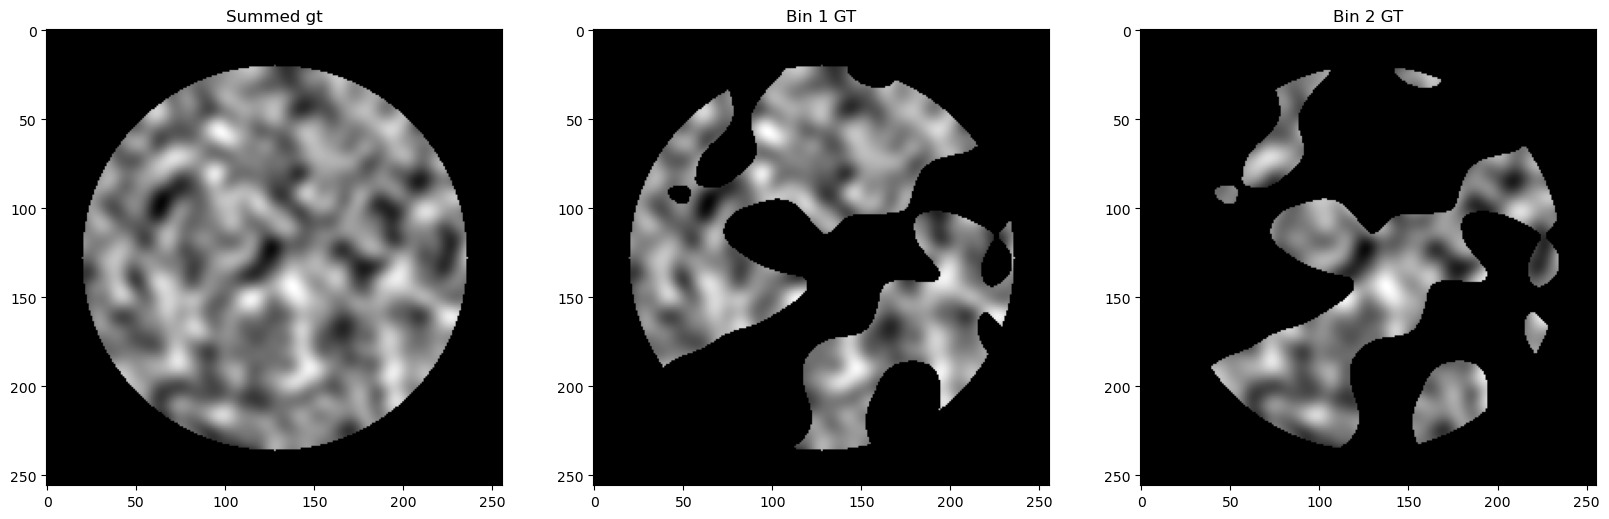

In [22]:
tst_binned = r2c(dataset[55][2])
tst_binned.shape

plt.figure(figsize=(20,10))
tst_gt = r2c(dataset[55][1])
plt.subplot(131)
plt.imshow(np.abs(tst_gt))
plt.title("Summed gt")
plt.gray()

plt.subplot(132)
plt.imshow(np.abs(tst_binned[0]))
plt.title("Bin 1 GT")
plt.gray()

plt.subplot(133)
plt.imshow(np.abs(tst_binned[1]))
plt.title("Bin 2 GT")
plt.gray()

plt.savefig('original_50')

In [35]:
tst_binned

tensor([[[0.+0.j, 0.+0.j, 0.+0.j,  ..., 0.+0.j, 0.+0.j, 0.+0.j],
         [0.+0.j, 0.+0.j, 0.+0.j,  ..., 0.+0.j, 0.+0.j, 0.+0.j],
         [0.+0.j, 0.+0.j, 0.+0.j,  ..., 0.+0.j, 0.+0.j, 0.+0.j],
         ...,
         [0.+0.j, 0.+0.j, 0.+0.j,  ..., 0.+0.j, 0.+0.j, 0.+0.j],
         [0.+0.j, 0.+0.j, 0.+0.j,  ..., 0.+0.j, 0.+0.j, 0.+0.j],
         [0.+0.j, 0.+0.j, 0.+0.j,  ..., 0.+0.j, 0.+0.j, 0.+0.j]],

        [[0.+0.j, 0.+0.j, 0.+0.j,  ..., 0.+0.j, 0.+0.j, 0.+0.j],
         [0.+0.j, 0.+0.j, 0.+0.j,  ..., 0.+0.j, 0.+0.j, 0.+0.j],
         [0.+0.j, 0.+0.j, 0.+0.j,  ..., 0.+0.j, 0.+0.j, 0.+0.j],
         ...,
         [0.+0.j, 0.+0.j, 0.+0.j,  ..., 0.+0.j, 0.+0.j, 0.+0.j],
         [0.+0.j, 0.+0.j, 0.+0.j,  ..., 0.+0.j, 0.+0.j, 0.+0.j],
         [0.+0.j, 0.+0.j, 0.+0.j,  ..., 0.+0.j, 0.+0.j, 0.+0.j]]])

In [36]:
tst_binned_sum = torch.sum(tst_binned,0)

/var/tmp/pbs.234286.pbs-7/ipykernel_1364681/125660704.py:1: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(np.abs(tst_binned_sum))


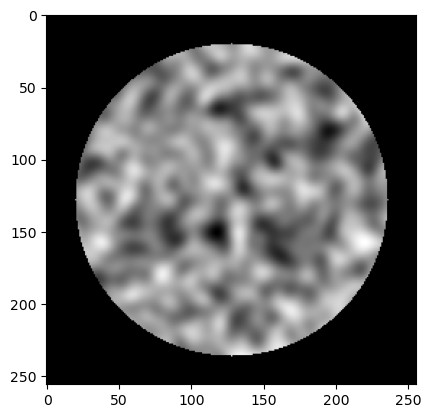

In [38]:
plt.imshow(np.abs(tst_binned_sum))

# Evaluation

/var/tmp/pbs.510060.pbs-7/ipykernel_3798969/1096742366.py:28: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(np.abs(binned_img[i]))


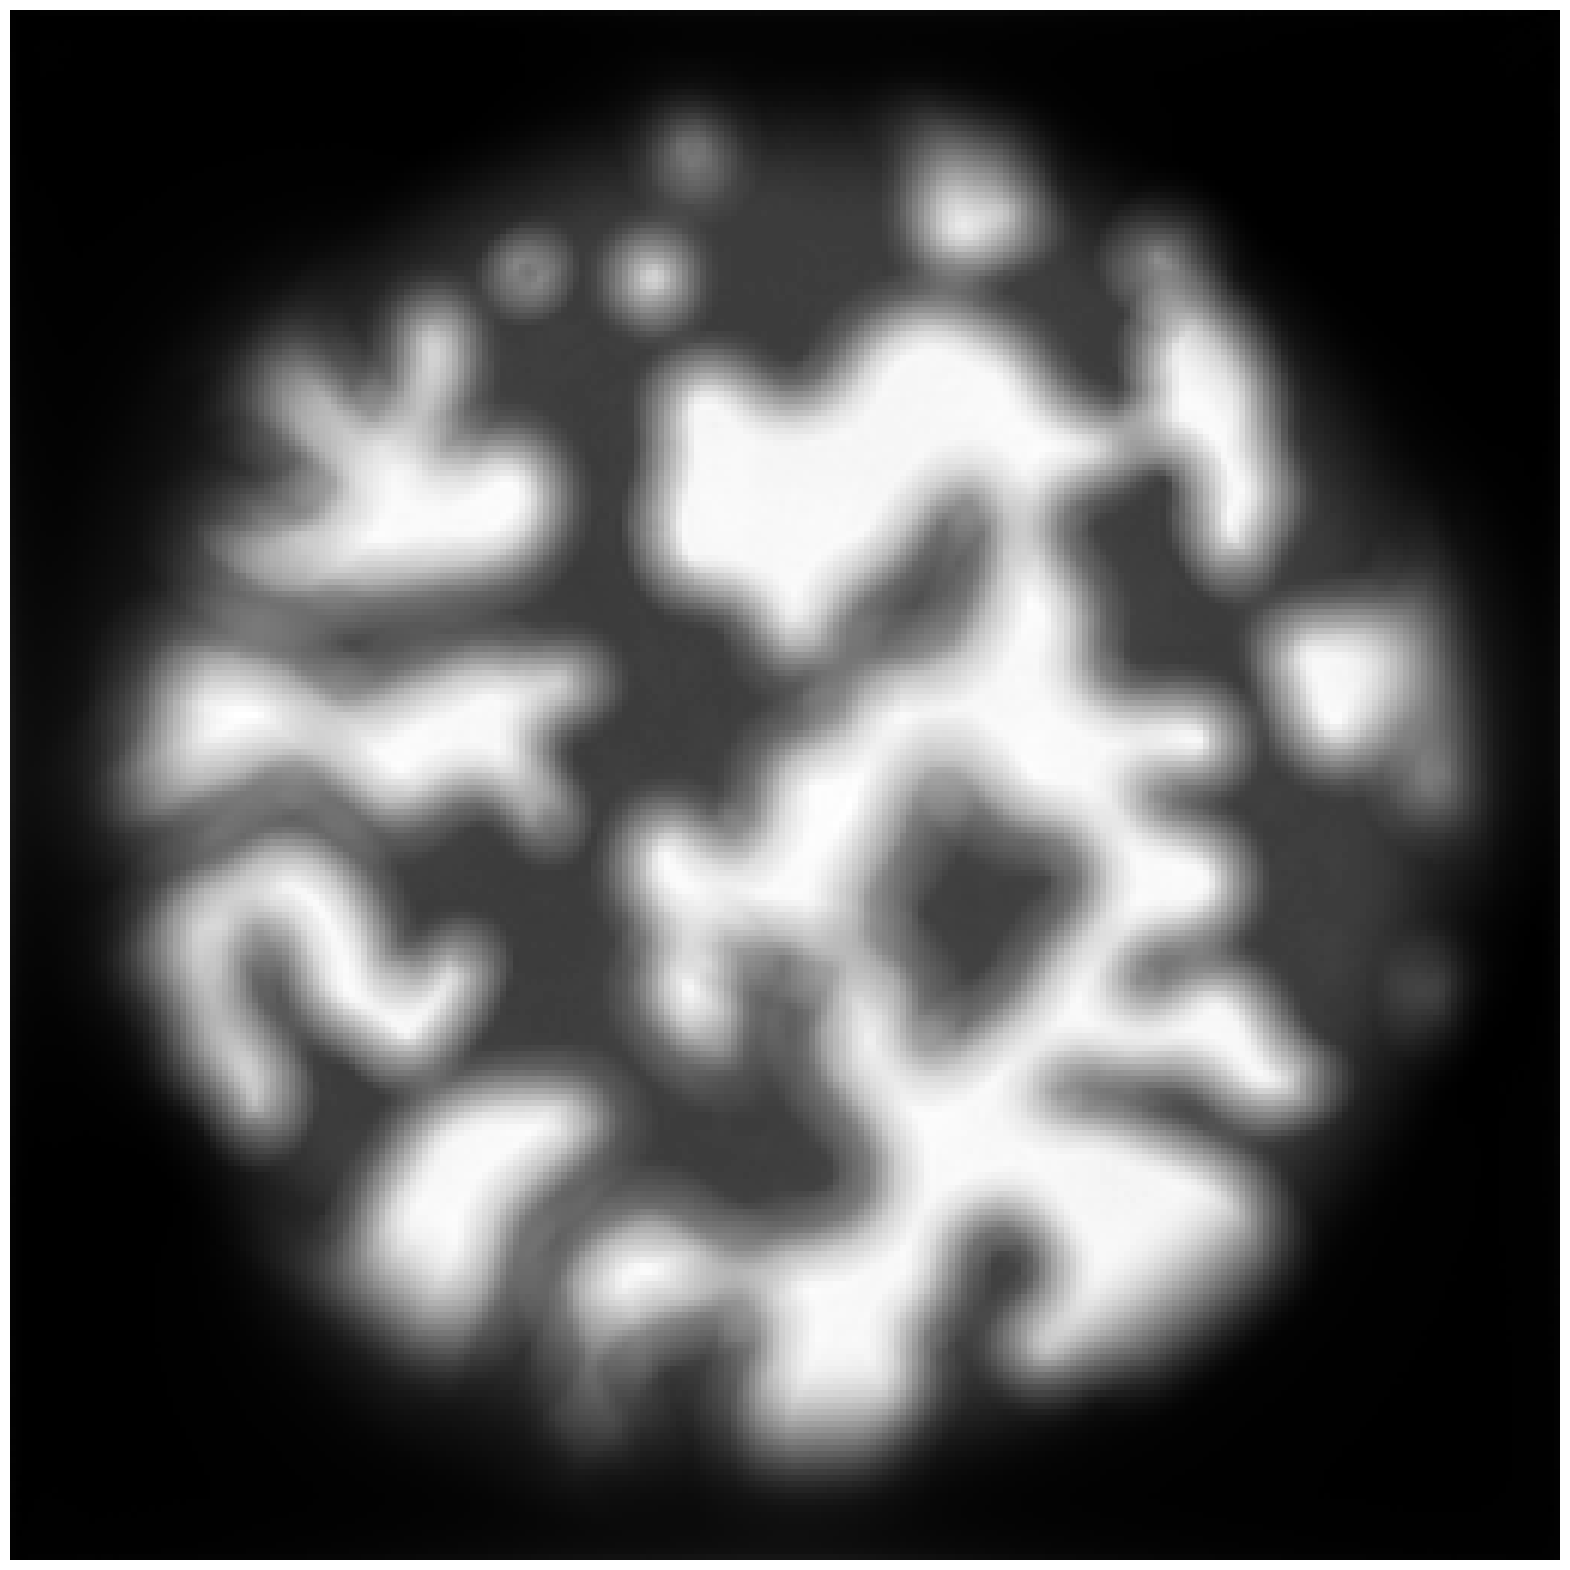

In [44]:
binned_img = r2c(tst_data[0].squeeze(0).detach().cpu(),0)
path = f"synthethic_imgs_11bins_sharp_softbins_spiral"
save_path = f'report_data/{path}'
import os
if not os.path.exists(save_path):
    # At this point, we know the directory is absent.
    os.makedirs(save_path)
    # Now the directory (and any necessary parent directories) has been created.
else:
    # If it already exists, we do nothing.
    pass


    
Ah_y = dataset[idx][3].squeeze(0).squeeze(0)
plt.imshow(np.abs(Ah_y))
plt.axis('off')
plt.gray()

plt.savefig(f'{save_path}/syn_img_A_img.png', format='png', dpi=200, bbox_inches="tight", transparent=True)
plt.savefig(f'{save_path}/syn_img_A_img.eps', format='eps', dpi=200, bbox_inches="tight", transparent=True)

# GT
gt_binned = r2c(dataset[idx][2],0)
for i in range(n_bins):
    # plt.subplot(1,n_bins, i +1)
    plt.imshow(np.abs(gt_binned[i]))
    # plt.title(f"Bin GT{i}")
    plt.gray()
    plt.axis('off')
    plt.savefig(f'{save_path}/syn_img_gt_bin_{i}.png', format='png', dpi=200, bbox_inches="tight", transparent=True)
    plt.savefig(f'{save_path}/syn_img_gt_bin_{i}.eps', format='eps', dpi=200, bbox_inches="tight", transparent=True)

gt_img = r2c(dataset[idx][1],0)

plt.imshow(np.abs(gt_img))
plt.axis('off')
plt.gray()

plt.savefig(f'{save_path}/syn_img_summed_gt.png', format='png', dpi=200, bbox_inches="tight", transparent=True)
plt.savefig(f'{save_path}/syn_img_summed_gt.eps', format='eps', dpi=200, bbox_inches="tight", transparent=True)

summed_img = np.zeros_like(binned_img[0])
plt.figure(figsize=(20,40))
for i in range(n_bins):
    # plt.subplot(1,n_bins, i +1)
    
    plt.imshow(np.abs(binned_img[i]))
    plt.axis('off')
    # plt.title(f"Output Bin {i}")
    plt.gray()
    plt.savefig(f'{save_path}/syn_img_out_bin_{i}.png', format='png', dpi=200, bbox_inches="tight", transparent=True)
    plt.savefig(f'{save_path}/syn_img_out_bin_{i}.eps', format='eps', dpi=200, bbox_inches="tight", transparent=True)
    summed_img += binned_img[i].numpy()

plt.imshow(np.abs(summed_img))
plt.axis('off')
plt.gray()

plt.savefig(f'{save_path}/syn_img_summed_out.png', format='png', dpi=200, bbox_inches="tight", transparent=True)
plt.savefig(f'{save_path}/syn_img_summed_out.eps', format='eps', dpi=200, bbox_inches="tight", transparent=True)

/var/tmp/pbs.510060.pbs-7/ipykernel_3798969/1058554176.py:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  plt.imshow(np.abs(gt_img))


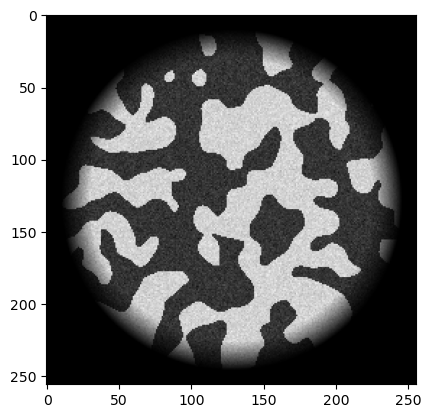

In [87]:
gt_img = r2c(dataset[idx][1],0)

plt.imshow(np.abs(gt_img))

In [99]:
binned_img = r2c(tst_data[0].squeeze(0).detach().cpu())
binned_img.shape

torch.Size([11, 256, 256])

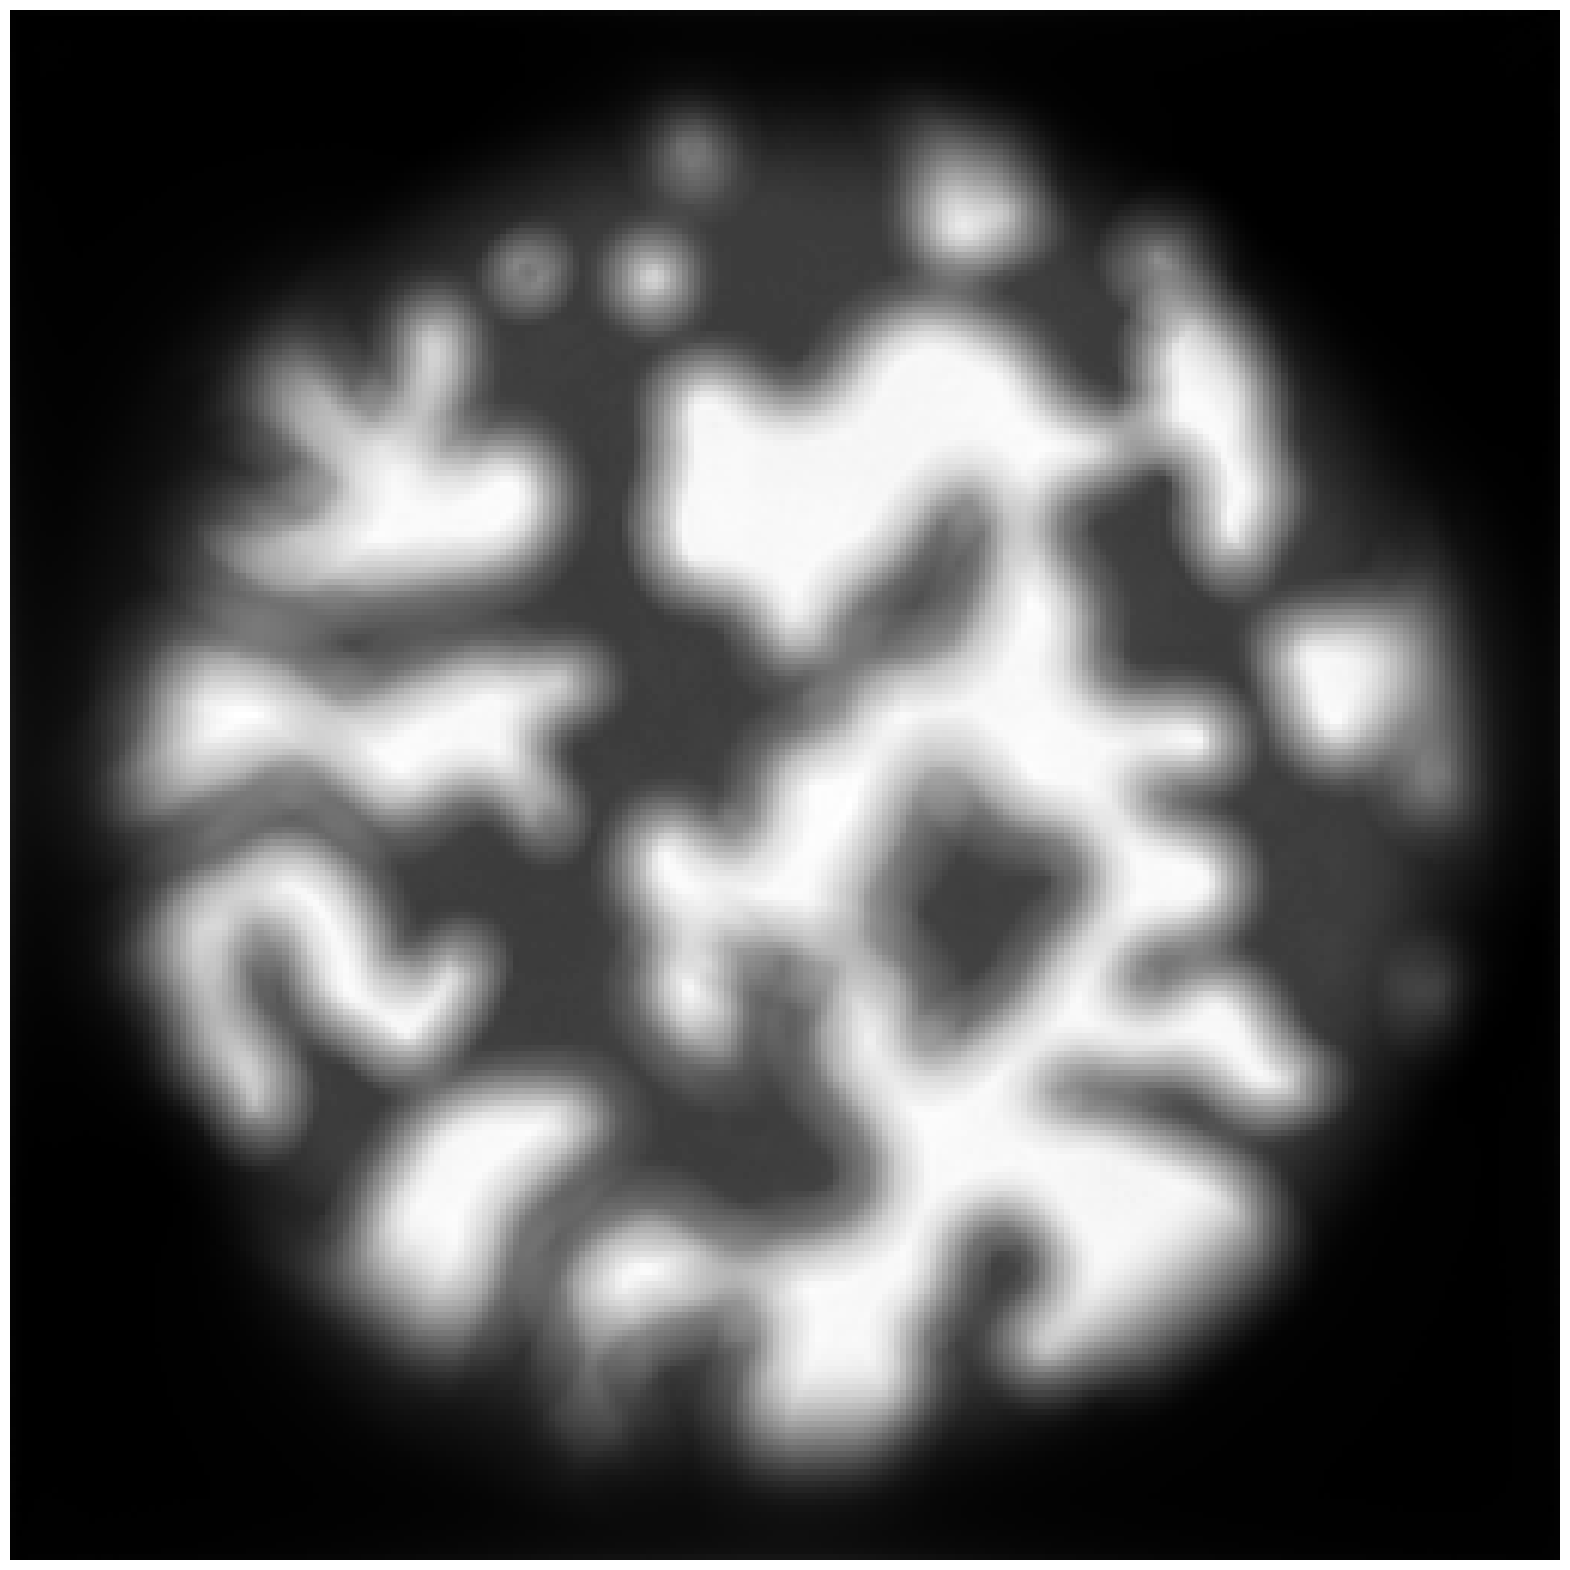

In [100]:
summed_img = np.zeros_like(binned_img[0].cpu())
plt.figure(figsize=(20,40))
for i in range(n_bins):
    # plt.subplot(1,n_bins, i +1)
    
    # plt.imshow(np.abs(binned_img[i]))
    # plt.axis('off')
    # plt.title(f"Output Bin {i}")
    # plt.gray()
    # plt.savefig(f'{save_path}/syn_img_out_bin_{i}.png', format='png', dpi=200, bbox_inches="tight", transparent=True)
    # plt.savefig(f'{save_path}/syn_img_out_bin_{i}.eps', format='eps', dpi=200, bbox_inches="tight", transparent=True)
    summed_img += binned_img[i].numpy()

plt.imshow(np.abs(summed_img))
plt.axis('off')
plt.gray()